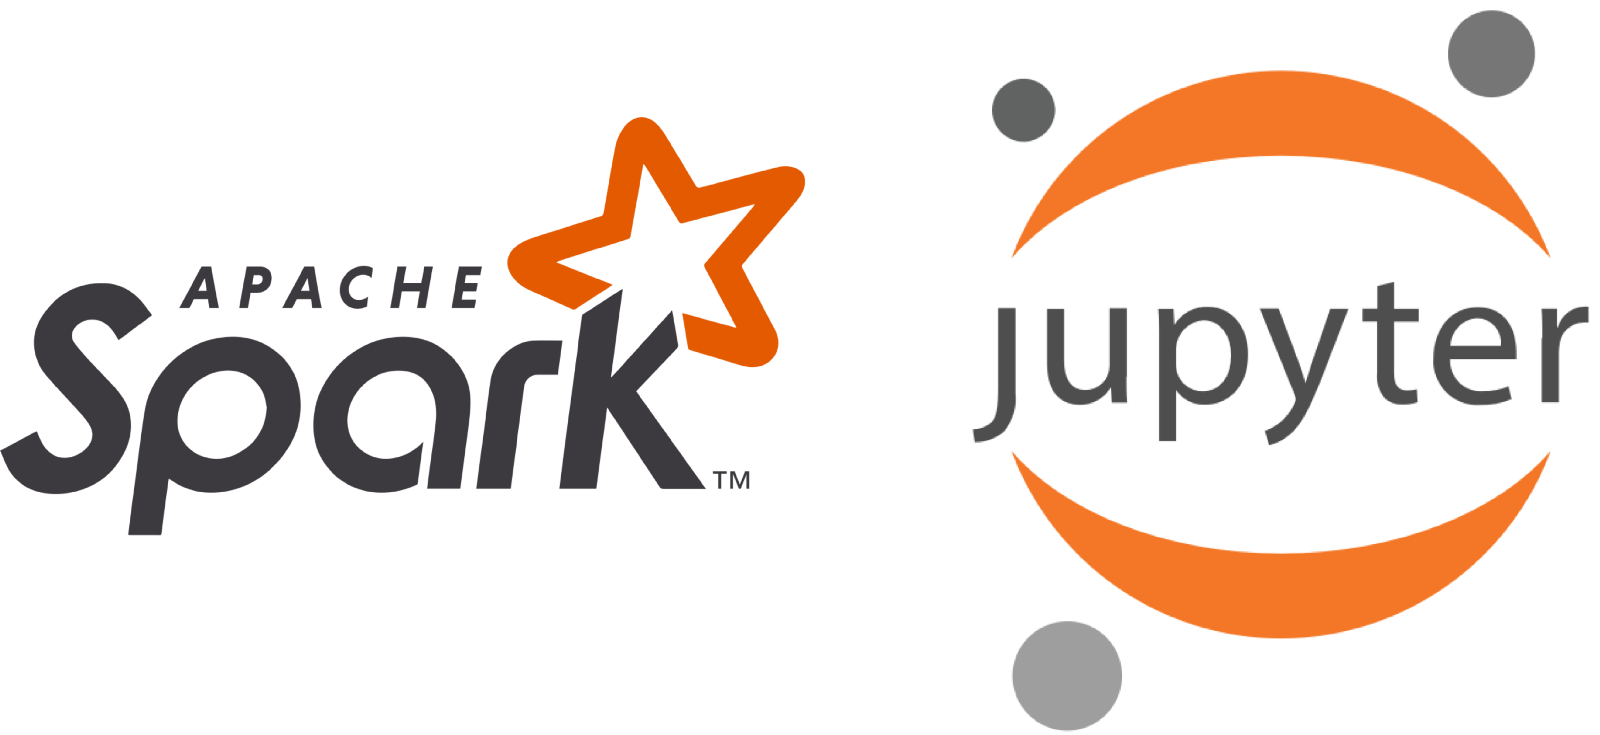

# How to find a needle in a very, very large haystack using Apache Spark and Jupyter

## Jupyter notebooks
First things first: this is a Jupyter notebook!

* Each box is a cell that can contain either Python code (or other languages), or Markdown.
* To execute a code cell, press Shift + Enter.

In [ ]:
# Example: press Shift + Enter in this box.

print("This cell was executed.")

You can enter _command mode_ by pressing Escape, and enter _edit mode_ by pressing Return.

This next cell will make things a bit prettier for the rest of the workshop:

In [ ]:
%matplotlib inline
%run init.py

# Import PySpark packages. Spark SQL functions are imported inside the "F" namespace
# (e.g. 'pyspark.sql.functions.mean' is imported as 'F.mean()')

from pyspark.sql import *
import pyspark.sql.functions as F

# Let's start using some Spark!

## Spotting fake reviews: Amazon Electronics

According to Amazon, [less than 1%](https://finance.yahoo.com/news/rise-fake-amazon-reviews-spot-175430368.html) of reviews are "fake". I'll let you decide whether that assessment seems accurate based on your experience, but let's assume a vast majority of reviews are legitimate and only a small minority are fake.

Here's a few examples of reviews clearly initiated by human or software bots...

<table>
    <tr>
    <td>
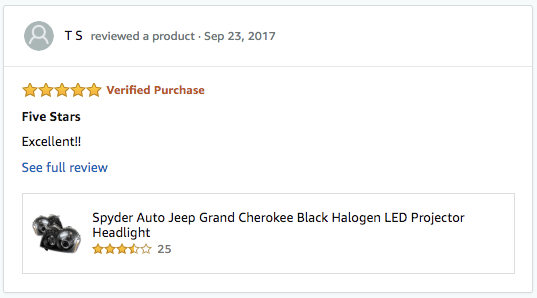
    </td><td>
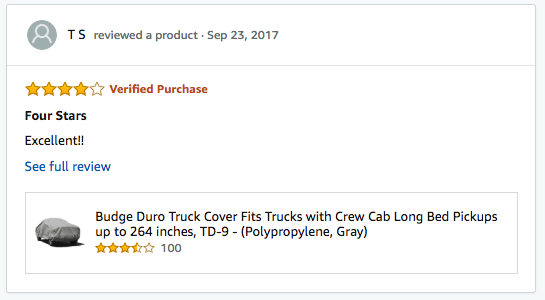
        </td><td>
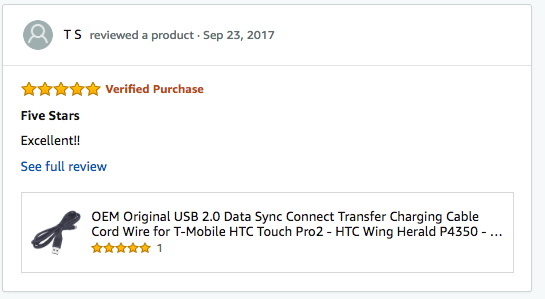
        </td>
    </tr>
</table>
<table>
    <tr>
    <td>
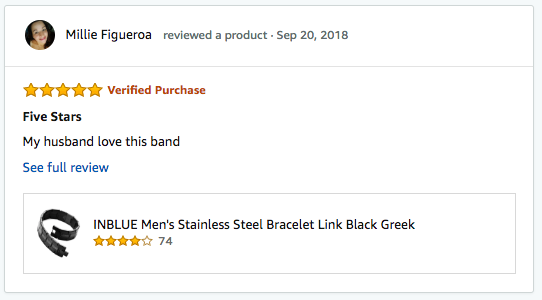
    </td><td>
        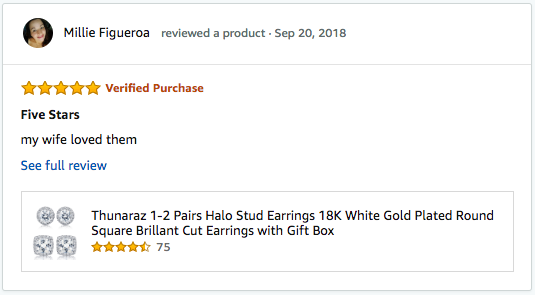
    </td>
    </tr>
</table>


Without _labels_, it's hard to validate in an automated way whether a candidate fake review is actually fake.

## Ideas for unsupervised identification of fake reviews

Let's assume a fake reviewer could be identified by looking at some simple heuristics, such as:

* The reviewer posts substantially more reviews than the typical user;
* Most of their reviews are positive;
* Most of their reviews are within a small time span;
* Most of their reviews are low quality (other users don't find them very helpful);
* Most of their reviews texts and titles are shorter than the average;
* Words like "sponsored" or "honest review" appear in the review.

(Start thinking of other ways you'd try to tackle this problem!)

Many of these heuristics are used in websites like [FakeSpot](http://fakespot.com) and [ReviewMeta](https://reviewmeta.com/) to determine which reviews can be trusted.

## The Data
We will work on a dataset of Amazon reviews from the Electronics department (originally from http://jmcauley.ucsd.edu/data/amazon/).

In the folder you were sent, there's a data file in JSON format. You can check its name by invoking a shell command from Jupyter (just prepend `!` to the cell to run a shell command):

In [ ]:
! ls -lh *.json

We see there's a JSON file that's approximately 1.4 G. Not quite big data, but no slouch either :)

<hr>

We can view the first few records using the `jq` command:

In [ ]:
! head reviews.json | jq

# Loading data

To load in a dataset, you use one of the `spark.read.{format}("path")` methods. 

In this case, the format is *JSON*, so we'll use `spark.read.json(path)`:

In [ ]:
reviews = spark.read.json("reviews.json")
reviews.cache()

The `reviews` object is a Spark DataFrame. In this dataset, each row is a review.

You can view the contents of the first few rows by using the `display` function:

In [ ]:
display(reviews)

...and you can see the number of rows in the dataframe calling the `.count()` method:

In [ ]:
print("There are ", reviews.count(), " reviews in this dataset.")

The columns in this file are:

* `asin`: an Amazon product identifier
* `date`: the date of the review
* `overall`: the user's review
* `summary`: the title of the review
* `reviewText`: the text of the review
* `reviewerID`: the ID of the user
* `reviewerName`: the name of the reviewer
* `total_rating`: how many people rated the review
* `fraction_helpful`: the fraction of people who found the review helpful

## Diversion: the Spark Web UI
If you navigate to [http://localhost:4040](http://localhost:4040), you will see the Spark Web UI. The Web UI works like a "Task Manager" for Spark -- you can see currently ongoing jobs, how those jobs are broken up into tasks, and _kill_ current tasks.

<hr>

# Heuristics for identifying fake reviews

Before breaking out a Machine Learning model on a dataset, the diligent Data Scientist will look at the properties of a dataset. This is called "Exploratory Data Analysis" (EDA). 


## Aggregations: let's look at the distribution of reviews (1-5 stars)

In [ ]:
# Take the reviews, group them by the number of star ("overall"), and
# count the number of reviews in each group.

reviews_by_stars = reviews \
    .groupBy("overall") \
    .agg(F.count("*").alias("count")) \
    .orderBy("overall")

display(reviews_by_stars)

### Let's dissect that call:

* We're calling several methods on the dataframe in a row. This is called a **pipeline**.
* I put each method call on a separate line to make it easier to see the flow. To tell Python that this is a multi-line statement, we put `\` at the end of each line.
* The `.groupBy()` method separates the data into groups
* The `.agg()` method computes an _aggregation_ on the groups, such that one value is returned for each group.
* The `F.` namespace contains a number of "SparkSQL" functions that can be used to do computations.

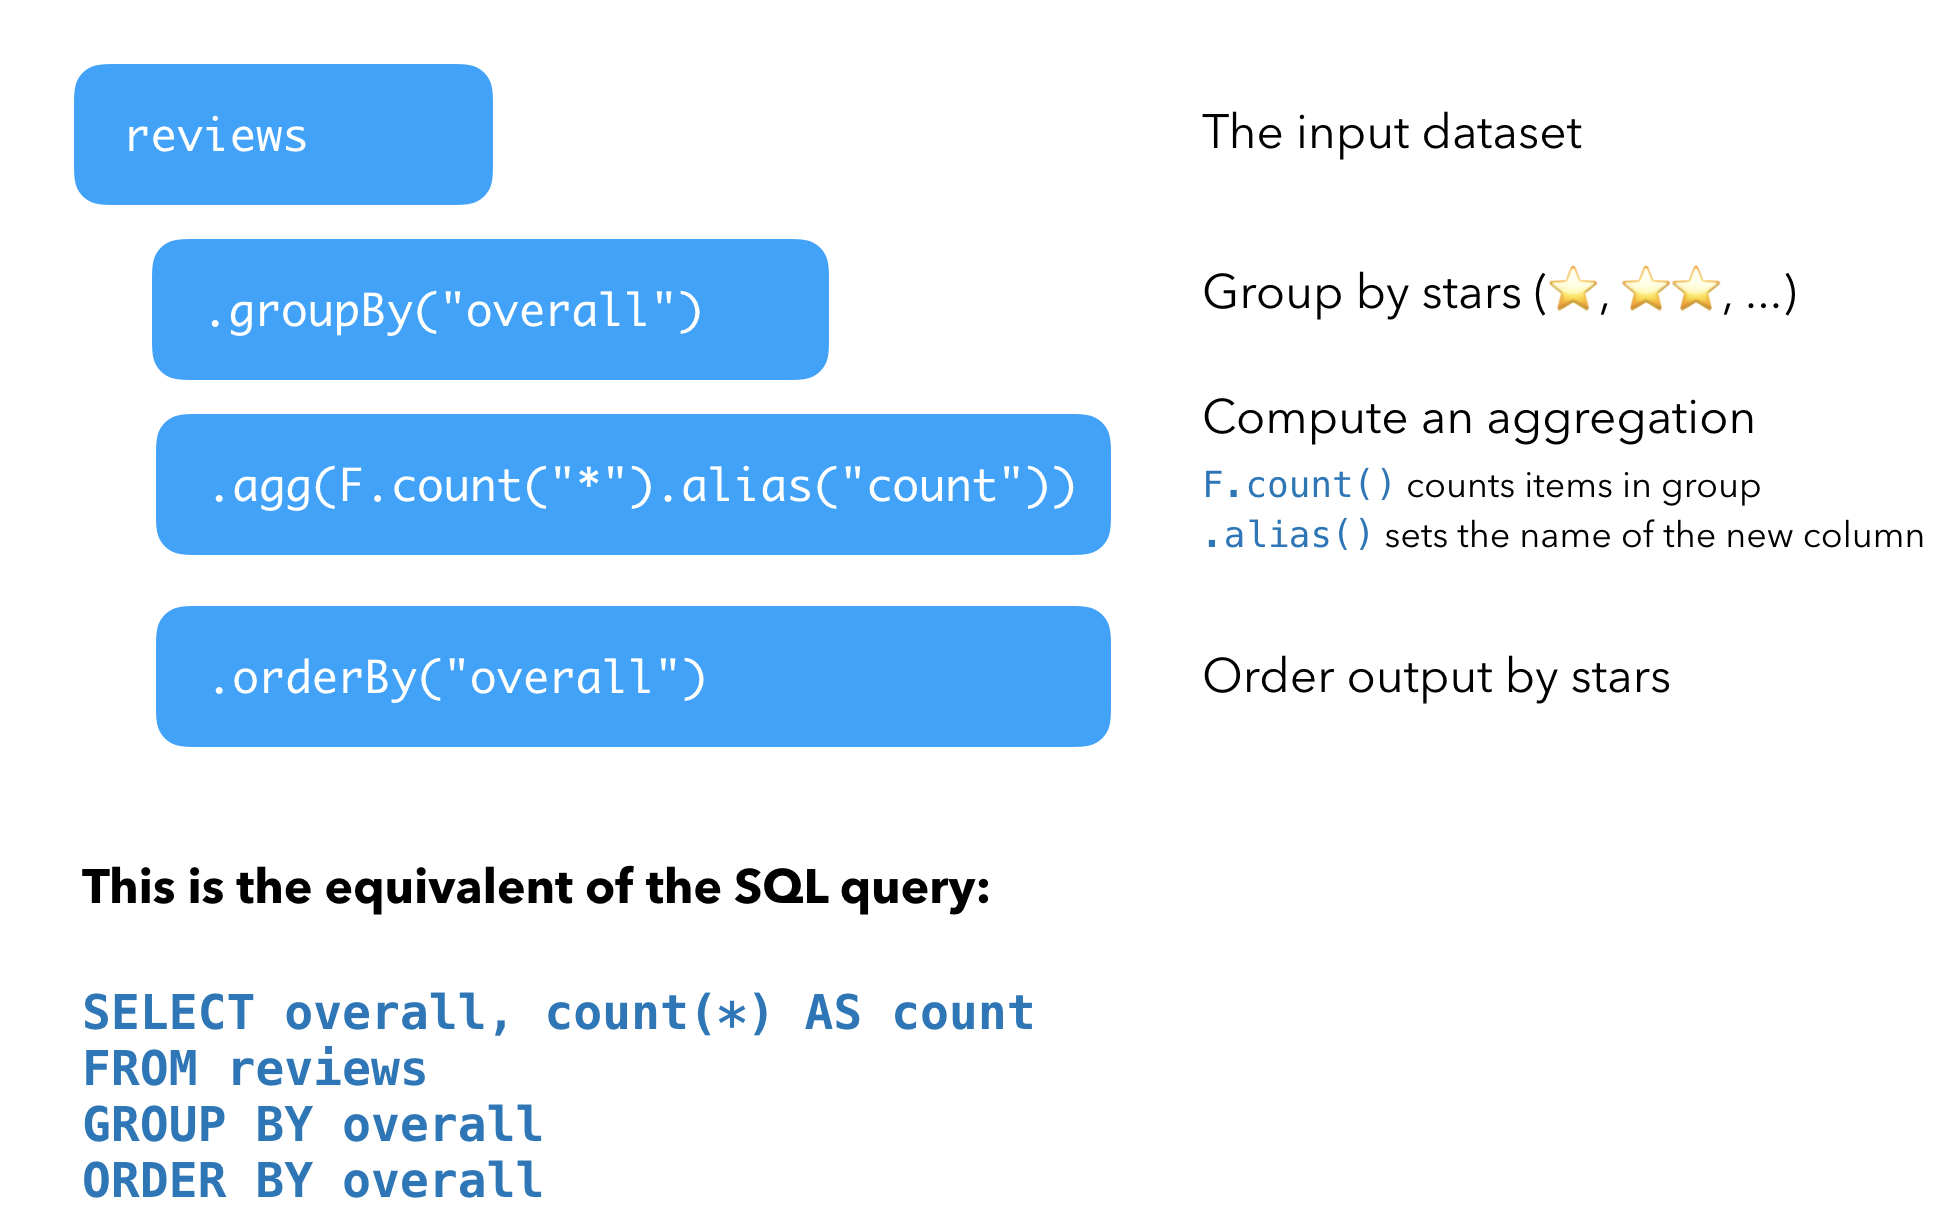

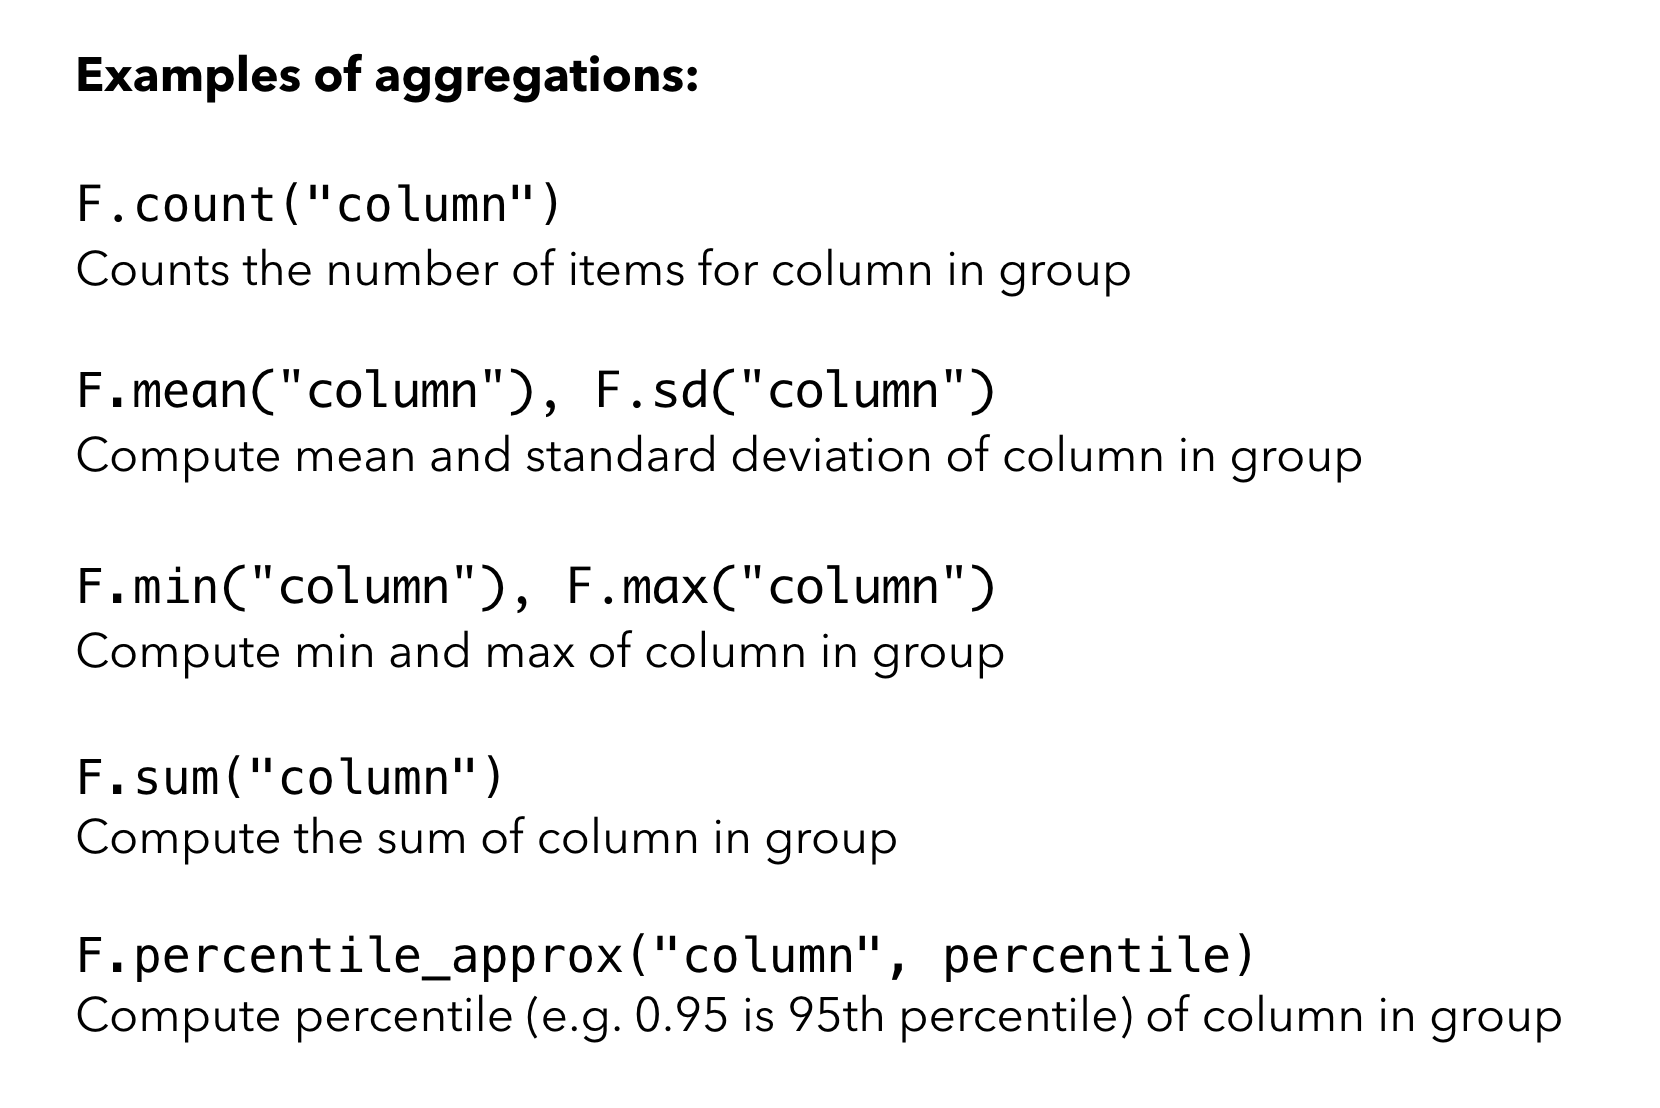

Let's visualize that distribution:

In [ ]:
reviews_by_stars.plot(x="overall", y="count", kind="scatter")

## How many reviews do users leave, typically?

Intuition: some users might leave way more reviews than others and way more often, especially if they have a financial incentive to do so.

**Task: for each reviewer, compute total number of reviews and review rate (# reviews/day)**

In [ ]:
# Group by reviewer ID and count reviews.
# Returns a table of number of reviews left by each user.

# Functions used:
# - groupBy -- to group the data (see above)
# - agg -- to specify an aggregation (see above)
# - count() -- to count items in group
# - datediff(date2, date1) -- computes difference in days between date2 and date1.
# - mean("overall") -- computes the average rating

count_reviews = reviews \
    .groupBy("reviewerID") \
    .agg(
        F.count("*").alias("count_reviews"),
        F.datediff(F.max("date"), F.min("date")).alias("activity_time_span"),
        F.mean("overall").alias("mean_overall"),
        F.mean("fraction_helpful").alias("mean_fraction_helpful")
    )

display(count_reviews)

In [ ]:
# I actually want the (number of reviews) / (1 + activity time span) to get daily rate of reviews posted

# The withColumn(columnName, columnExpression) method adds a new column.
# F.expr takes a string expression.
count_reviews = count_reviews.withColumn("reviews_per_day", F.expr("count_reviews / (1+activity_time_span)"))

display(count_reviews)

In [ ]:
# Plot a histogram of the number of reviews
count_reviews.plot(x="count_reviews", kind="hist")

In [ ]:
# Plot a histogram of the number of reviews, but use a logarithmic Y axis instead

count_reviews.plot(x="count_reviews", kind="hist", logy=True)

In [ ]:
# Plot a histogram of the review posting rate

count_reviews.plot(x="reviews_per_day", kind="hist")

The *vast* majority of users leaves fewer than 50 reviews, and posts 1 or fewer reviews per day. 

### How do we quantify this more precisely?

The function `percentile_approx` is an aggregation function that returns an approximate percentile. 

In [ ]:
# Compute 50th (median), 90th, 95th, and 99th percentile (X percentile: X% of users left this many reviews or fewer).
# When you don't groupBy() first, agg() computes a summary on the whole dataset

perc_count_reviews = count_reviews.agg(
    F.percentile_approx("count_reviews", 0.5).alias("median"),
    F.percentile_approx("count_reviews", 0.9).alias("90"),
    F.percentile_approx("count_reviews", 0.95).alias("95"),
    F.percentile_approx("count_reviews", 0.99).alias("99"),
    F.max("count_reviews").alias("max")
)

display(perc_count_reviews)

In [ ]:
# TODO: Compute 50th, 90th, 95th, and 99th percentile for posting rate of reviews (column "reviews_per_day") 

perc_rate_reviews = count_reviews.agg(...)

display(perc_rate_reviews)

(scroll down for solution)
<div style="height:1000px"></div>

In [ ]:
# Solution

# perc_rate_reviews = count_reviews.agg(
#     F.percentile_approx("reviews_per_day", 0.5).alias("median"),
#     F.percentile_approx("reviews_per_day", 0.9).alias("90"),
#     F.percentile_approx("reviews_per_day", 0.95).alias("95"),
#     F.percentile_approx("reviews_per_day", 0.99).alias("99"),
#     F.max("reviews_per_day").alias("max")
# )

# display(perc_rate_reviews)

Let's find what those reviewers look like! 

We take `count_reviews` (a table of reviewer IDs and reviewer metrics) and join it with the `review` table, using `reviewerID` as the joining column. As a reminder, this is what `count_reviews` looked like:

In [ ]:
display(count_reviews, n = 3)

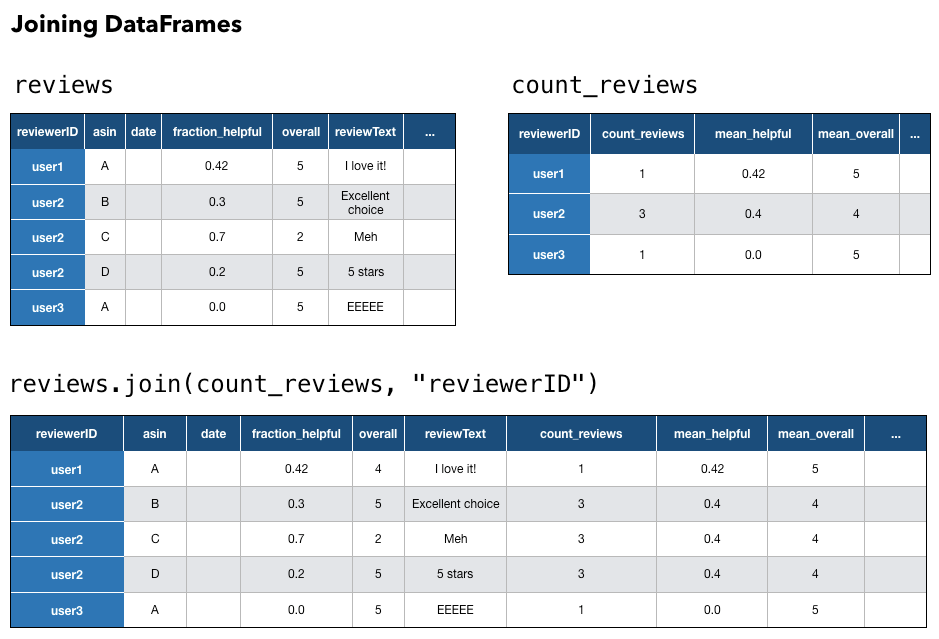

In [ ]:
reviews_with_counts = reviews.join(count_reviews, "reviewerID")

# Check it out! Now all the new columns we created are in the new table
display(reviews_with_counts, n=4)

Let's look at that 5% tail of users with more than 19 reviews, and more than 2.6 reviews per day (you computed this two cells ago).

In [ ]:
suspicious_reviews = reviews_with_counts \
    .filter("count_reviews > 19 and reviews_per_day > 2.6") \
    .orderBy("reviewerID")
    
display(suspicious_reviews, n=40)

<br>
<div style="text-align:center; font-size: 5rem;">🧐 HMMM...</div>


<br>
"Ben" left 22 reviews in three days, all five stars, all with the same title. 

In [ ]:
suspicious_reviews.count() / reviews.count()

Let's add a `is_fake_candidate` column to our reviews dataset. We can use `F.expr()` to return a boolean (True or False) column using the same condition as the `.filter()` call:

In [ ]:
reviews_with_counts = reviews_with_counts \
    .withColumn("is_fake_candidate", F.expr("count_reviews > 19 and reviews_per_day > 2.6"))

# There should now be an `is_fake_candidate` column now
display(reviews_with_counts)

# Are reviews in the "suspicious" set different from the general set?

## Example: helpfulness

In [ ]:
display(reviews_with_counts.groupBy("is_fake_candidate").agg(
    F.mean("fraction_helpful")
))

The average helpfulness fraction is only ~11% for reviews in the "suspicious" set we identified, versus ~32% in the general population.

## Exercise: Length of reviews

Remember how we suspected that the review length and title length might be, on average, shorter for fake reviews than real reviews?

Let's try to validate this hunch. 

You'll need:
- the name of the columns containing title and body of the review
- the function `F.length()`, which computes the number of characters in a column

The output should be a new DataFrame with columns `title_length` and `text_length`.

In [ ]:
# TODO: Create a new dataframe with two columns representing the lengths of title and body
reviews_with_lengths = reviews_with_counts \
    .withColumn(..., ...) \
    .withColumn(..., ...)

Next, let's look at the median `title_length` and `text_length` for "suspicious" vs. "non-suspicious" reviews.

In [ ]:
# TODO: Display the median length of title and body for suspicious reviews vs. all reviews
display(reviews_with_lengths.groupBy("XXX").agg(
    ...,
    ...
))

When you're done, scroll down to continue.

<div style="height:1000px"></div>

In [ ]:
# Create a new dataframe with two columns representing the lengths of title and body
reviews_with_lengths = reviews_with_counts \
    .withColumn("title_length", F.length("summary")) \
    .withColumn("text_length", F.length("reviewText"))

# Let's check this looks correct
display(reviews_with_lengths, n=5)

In [ ]:
# Display the average length of title and body for suspicious reviews vs. all reviews
display(reviews_with_lengths.groupBy("is_fake_candidate").agg(
    F.percentile_approx("title_length", 0.5),
    F.percentile_approx("text_length", 0.5)
))

That table should highlight the difference, but plotting the distribution of lengths for "suspicious" vs. all 
reviews will show differences much more clearly!

In [ ]:
# Plot histograms of title lengths for all reviews. norm_hist normalizes the histogram.
reviews_with_lengths.plot(x="title_length", kind="hist", norm_hist=True)
reviews_with_lengths.filter("is_fake_candidate").plot(x="title_length", kind="hist", norm_hist=True)

In [ ]:
# Plot histograms of body lengths for all reviews. norm_hist normalizes the histogram.
reviews_with_lengths.plot(x="text_length", kind="hist", norm_hist=True)
reviews_with_lengths.filter("is_fake_candidate").plot(x="text_length", kind="hist", norm_hist=True)

The plot above is not super-helpful because there's a very long tail in the lengths of review bodies. _Logarithmic scales_ to the rescue!

In [ ]:
# Plotting on a logarithmic scale makes it easier to look at the tails of the distribution.
# Plot histograms of body lengths for all reviews. norm_hist normalizes the histogram.
reviews_with_lengths.plot(x="text_length", kind="hist", norm_hist=True, logx=True)
reviews_with_lengths.filter("is_fake_candidate").plot(x="text_length", kind="hist", norm_hist=True, logx=True)

When we plot using a logarithmic axis, it becomes a lot clearer that there's a significant tail of reviews with very *short* (<100 characters) body. **For reference, this box has exactly 200 characters.**

# Free-form task: for what product are reviews most "inflated"?

Each product is uniquely identified by `asin`. 

Find the product that might have the most inflated reviews based on your hunches on what fake reviews look like.

Some ideas:
- One of the heuristics we already computed
- Mean or median review lengths
- Number of reviews we marked as "suspicious"
- Review posting rate for an item (i.e. number of reviews posted in a time interval)
- Contain the sentence "honest review", "sponsored", or whatever you think indicates a potential fake (use the SQL expression `like` inside `expr()`, example:

```
df.withColumn("contains_sponsored", expr("reviewText like '%sponsored%'")) 
```
- ...

Once you have set up your query:
1. Identify one or two candidate products by `asin`
2. Search for the `asin` on Amazon.com (just enter it in the search bar)
3. copy the Amazon URL into [https://www.fakespot.com/](https://www.fakespot.com/) to check what their model thinks about the reviews.

In [ ]:
# TODO: Do the exercise!
#
#
# If you get stuck, scroll down for a worked out example.

<div style="height:1000px"></div>
The example below is for illustrative purposes:

In [ ]:
# A worked out example:
# 
fakes = reviews_with_lengths.groupBy("asin").agg(F.count("is_fake_candidate").alias("count_fake_candidates"))

# Show in descending count of fakes
display(fakes.orderBy(F.desc("count_fake_candidates")))

`B007WTAJTO` corresponds to this [Amazon product.](https://www.amazon.com/SanDisk-Ultra-MicroSDXC-Memory-Adapter/dp/B007WTAJTO?keywords=B007WTAJTO&qid=1537732058&sr=8-1&ref=sr_1_1) 

This product earned [a grade of "D" on Fakespot](https://www.fakespot.com/product/sandisk-ultra-64gb-microsdxc-class-10-uhs-memory-card-speed-up-to-30mb-s-with-adapter-sdsdqua-064g-u46a-old-version).

# Where does a Data Scientist go next?

...back to the presentation!